In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
sns.set()
%matplotlib inline

In [2]:
db = pd.read_csv('../data/clean_data.csv', na_values=['?', None])
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
db.head()

Unnamed: 0     Bearer Id            Start  Start ms              End  \
0           0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   
1           1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   
2           2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   
3           3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   
4           4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   

   End ms  Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0   662.0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1   606.0  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2   652.0  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3   171.0  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4   954.0  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  Avg RTT DL (ms)  Avg RTT UL (ms)  \
0  9.16456699548519E+015             42.0              5.0   
1                L77566A             65.0              5.0   
2                D42335A              NaN              NaN   
3                T21824A              NaN              NaN   
4                D88865A              NaN              NaN   

   Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  DL TP < 50 Kbps (%)  \
0                     23.0                     44.0                100.0   
1                     16.0                     26.0                100.0   
2                      6.0                      9.0                100.0   
3                     44.0                     44.0                100.0   
4                      6.0                      9.0                100.0   

   50 Kbps < DL TP < 250 Kbps (%)  250 Kbps < DL TP < 1 Mbps (%)  \
0                             0.0                            0.0   
1                             0.0                            0.0   
2                             0.0                            0.0   
3                             0.0                            0.0   
4                             0.0                            0.0   

   DL TP > 1 Mbps (%)  UL TP < 10 Kbps (%)  10 Kbps < UL TP < 50 Kbps (%)  \
0                 0.0                100.0                            0.0   
1                 0.0                100.0                            0.0   
2                 0.0                100.0                            0.0   
3                 0.0                100.0                            0.0   
4                 0.0                100.0                            0.0   

   50 Kbps < UL TP < 300 Kbps (%)  UL TP > 300 Kbps (%)  \
0                             0.0                   0.0   
1                             0.0                   0.0   
2                             0.0                   0.0   
3                             0.0                   0.0   
4                             0.0                   0.0   

   Activity Duration DL (ms)  Activity Duration UL (ms)   Dur. (ms).1  \
0                    37624.0                    38787.0  1.823653e+09   
1                      168.0                     3560.0  1.365104e+09   
2                        0.0                        0.0  1.361763e+09   
3                     3330.0                    37882.0  1.321510e+09   
4                        0.0                        0.0  1.089009e+09   

  Handset Manufacturer                 Handset Type  \
0              Samsung   Samsung Galaxy A5 Sm-A520F   
1              Samsung  Samsung Galaxy J5 (Sm-J530)   
2              Samsung     Samsung Galaxy A8 (2018)   
3            undefined                    undefined   
4              Samsung             Samsung Sm-G390F   

   Nb of sec with Vol DL < 6250B  Nb of sec with Vol UL < 1250B  \
0                          213.0                          214.0   
1                          971.0                         1022.0   
2                          751.0                          695.0   
3                           17.0                      

In [4]:
db['MSISDN/Number'] = db['MSISDN/Number'].astype("category")
db['Handset Type'] = db['Handset Type'].astype("category")
cleaned_df = db

In [5]:
experience_df = cleaned_df[['MSISDN/Number', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 
           'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'Handset Type']]

experience_df.head()

MSISDN/Number  Avg RTT DL (ms)  Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  \
0  3.366496e+10             42.0              5.0                     23.0   
1  3.368185e+10             65.0              5.0                     16.0   
2  3.376063e+10              NaN              NaN                      6.0   
3  3.375034e+10              NaN              NaN                     44.0   
4  3.369980e+10              NaN              NaN                      6.0   

   Avg Bearer TP UL (kbps)                 Handset Type  
0                     44.0   Samsung Galaxy A5 Sm-A520F  
1                     26.0  Samsung Galaxy J5 (Sm-J530)  
2                      9.0     Samsung Galaxy A8 (2018)  
3                     44.0                    undefined  
4                      9.0             Samsung Sm-G390F

In [6]:
def handle_outliers(df, col, method="lower_upper"):
    df = df.copy()
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    
    lower_bound = q1 - ((1.5) * (q3 - q1))
    upper_bound = q3 + ((1.5) * (q3 - q1))
    
    if method == "mean":
        df[col] = np.where(df[col] < lower_bound,   df[col].mean(), df[col])
        df[col] = np.where(df[col] > upper_bound, df[col].mean(), df[col])
    
    elif  method == "mode":
        df[col] = np.where(df[col] < lower_bound,   df[col].mode()[0], df[col])
        df[col] = np.where(df[col] > upper_bound, df[col].mode()[0], df[col])
    else:
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df

In [7]:
cleaned_experience_df = handle_outliers(experience_df, 'Avg RTT DL (ms)', method="mean")
cleaned_experience_df = handle_outliers(experience_df, 'Avg RTT UL (ms)', method="mean")

cleaned_experience_df = handle_outliers(experience_df, 'Avg Bearer TP DL (kbps)', method="mean")
cleaned_experience_df = handle_outliers(experience_df, 'Avg Bearer TP UL (kbps)', method="mean")


In [8]:
cleaned_df.dtypes


Unnamed: 0                           int64
Bearer Id                          float64
Start                               object
Start ms                           float64
End                                 object
End ms                             float64
Dur. (ms)                          float64
IMSI                               float64
MSISDN/Number                     category
IMEI                               float64
Last Location Name                  object
Avg RTT DL (ms)                    float64
Avg RTT UL (ms)                    float64
Avg Bearer TP DL (kbps)            float64
Avg Bearer TP UL (kbps)            float64
DL TP < 50 Kbps (%)                float64
50 Kbps < DL TP < 250 Kbps (%)     float64
250 Kbps < DL TP < 1 Mbps (%)      float64
DL TP > 1 Mbps (%)                 float64
UL TP < 10 Kbps (%)                float64
10 Kbps < UL TP < 50 Kbps (%)      float64
50 Kbps < UL TP < 300 Kbps (%)     float64
UL TP > 300 Kbps (%)               float64
Activity Du

In [9]:
experience_metrics_df = pd.DataFrame(columns=['MSISDN/Number', 'Handset Type', 'Avg RTT DL (ms)',
                                              'avg_throughput_kbps', 'tcp_retrans_bytes'])

experience_metrics_df['avg_rtt_ms'] = cleaned_experience_df['Avg RTT DL (ms)'] + cleaned_experience_df['Avg RTT UL (ms)']
experience_metrics_df['avg_throughput_kbps'] = cleaned_experience_df['Avg Bearer TP DL (kbps)'] + cleaned_experience_df['Avg Bearer TP UL (kbps)']

experience_metrics_df['msisdn'] = cleaned_experience_df['MSISDN/Number']
experience_metrics_df['handset_type'] = cleaned_experience_df['Handset Type']

In [10]:
experience_metrics_df.head()

MSISDN/Number Handset Type Avg RTT DL (ms)  avg_throughput_kbps  \
0           NaN          NaN             NaN                 67.0   
1           NaN          NaN             NaN                 42.0   
2           NaN          NaN             NaN                 15.0   
3           NaN          NaN             NaN                 88.0   
4           NaN          NaN             NaN                 15.0   

  tcp_retrans_bytes  avg_rtt_ms        msisdn                 handset_type  
0               NaN        47.0  3.366496e+10   Samsung Galaxy A5 Sm-A520F  
1               NaN        70.0  3.368185e+10  Samsung Galaxy J5 (Sm-J530)  
2               NaN         NaN  3.376063e+10     Samsung Galaxy A8 (2018)  
3               NaN         NaN  3.375034e+10                    undefined  
4               NaN         NaN  3.369980e+10             Samsung Sm-G390F

In [11]:
experience_metrics_df.describe()

avg_throughput_kbps     avg_rtt_ms
count        150001.000000  122161.000000
mean          13867.862210     127.024885
std           24522.265649     622.521925
min               0.000000       0.000000
25%              90.000000      38.000000
50%             125.000000      54.000000
75%           21028.417091      92.000000
max          379930.417091   96924.000000

In [12]:
experience_agg_by_customer = experience_metrics_df.groupby('msisdn').agg({'avg_rtt_ms': 'sum',
                                                                          'avg_throughput_kbps': 'sum',
                                                                          'tcp_retrans_bytes': 'sum', 
                                                                           'handset_type': lambda x: x.mode()[0]})

In [13]:
experience_agg_by_customer.head()

avg_rtt_ms  avg_throughput_kbps  tcp_retrans_bytes  \
msisdn                                                              
33601001722.0        46.0            76.000000                  0   
33601001754.0        31.0            99.000000                  0   
33601002511.0         0.0            97.000000                  0   
33601007832.0        84.0           248.000000                  0   
33601008617.0       119.0         42205.417091                  0   

                                 handset_type  
msisdn                                         
33601001722.0  Huawei P20 Lite Huawei Nova 3E  
33601001754.0          Apple iPhone 7 (A1778)  
33601002511.0                       undefined  
33601007832.0         Apple iPhone 5S (A1457)  
33601008617.0         Apple iPhone Se (A1723)

In [14]:
tcp_trans = experience_agg_by_customer.sort_values(by=['tcp_retrans_bytes'], ascending=False)

top_10_tcp = tcp_trans.head(10)
bot_10_tcp = tcp_trans.tail(10)
most_tcp_frq = tcp_trans['tcp_retrans_bytes'].value_counts().head(10)

In [15]:
top_10_tcp[['tcp_retrans_bytes']]

tcp_retrans_bytes
msisdn                          
33601001722.0                  0
33669138905.0                  0
33669159170.0                  0
33669158963.0                  0
33669158559.0                  0
33669158353.0                  0
33669157841.0                  0
33669156988.0                  0
33669156909.0                  0
33669156713.0                  0

In [16]:
bot_10_tcp[['tcp_retrans_bytes']]

tcp_retrans_bytes
msisdn                              
33659400654.0                      0
33659400609.0                      0
33659400378.0                      0
33659400313.0                      0
33659400021.0                      0
33659399917.0                      0
33659399844.0                      0
33659399731.0                      0
33659399655.0                      0
882397108489451.0                  0

In [17]:
tcp_rtt = experience_agg_by_customer.sort_values(by=['avg_rtt_ms'], ascending=False)

top_10_rtt = tcp_rtt.head(10)
bot_10_rtt = tcp_rtt.tail(10)
most_rtt_frq = tcp_rtt['avg_rtt_ms'].value_counts().head(10)


In [18]:
top_10_rtt[['avg_rtt_ms']]

avg_rtt_ms
msisdn                   
33626320676.0    306101.0
33662317023.0     96924.0
33660874265.0     64670.0
33683692867.0     54848.0
33698551167.0     46021.0
33761813523.0     37084.0
33668791629.0     36304.0
33760941100.0     27278.0
33606788933.0     26300.0
33671816754.0     25715.0

In [19]:
bot_10_rtt[['avg_rtt_ms']]

avg_rtt_ms
msisdn                       
33662288455.0             0.0
33662289075.0             0.0
33662294327.0             0.0
33662295833.0             0.0
33662296356.0             0.0
33750236009.0             0.0
33662297887.0             0.0
33662298430.0             0.0
33662298574.0             0.0
882397108489451.0         0.0

In [20]:
most_rtt_frq

0.0     18546
29.0     2778
39.0     2245
38.0     1541
30.0     1478
40.0     1466
28.0     1373
49.0     1268
31.0     1096
41.0     1095
Name: avg_rtt_ms, dtype: int64

In [21]:
tcp_throuput = experience_agg_by_customer.sort_values(by=['avg_throughput_kbps'], ascending=False)

top_10_throuput = tcp_throuput.head(10)
bot_10_throuput = tcp_throuput.tail(10)
most_rtt_throuput = tcp_throuput['avg_throughput_kbps'].value_counts().head(10)


In [22]:
top_10_throuput[['avg_throughput_kbps']]

avg_throughput_kbps
msisdn                            
33626320676.0         1.714307e+07
33762333464.0         8.595801e+05
33668708263.0         6.880757e+05
33659546392.0         6.850933e+05
33668425947.0         6.657687e+05
33698174760.0         6.123773e+05
33669946573.0         5.882907e+05
33625700673.0         5.627504e+05
33658581169.0         5.161238e+05
33650760733.0         4.846031e+05

In [23]:
bot_10_throuput[['avg_throughput_kbps']]

avg_throughput_kbps
msisdn                            
33660500494.0                  0.0
33650957457.0                  0.0
33638414072.0                  0.0
33698591046.0                  0.0
33752920509.0                  0.0
33777464744.0                  0.0
33777761538.0                  0.0
33660615626.0                  0.0
33669225540.0                  0.0
33660874647.0                  0.0

In [24]:
most_rtt_throuput

15.0    2685
63.0    2072
97.0    1023
90.0    1005
98.0     971
96.0     866
99.0     853
89.0     817
95.0     798
91.0     793
Name: avg_throughput_kbps, dtype: int64

In [25]:

handset_agg = experience_agg_by_customer.groupby('handset_type').agg({'avg_throughput_kbps': 'sum',
                                                                       'tcp_retrans_bytes': 'sum'})
handset_agg.head()


avg_throughput_kbps  tcp_retrans_bytes
handset_type                                                             
A-Link Telecom I. Cubot A5                     23510.0                  0
A-Link Telecom I. Cubot Note Plus               6699.0                  0
A-Link Telecom I. Cubot Note S                  8937.0                  0
A-Link Telecom I. Cubot Nova                   56217.0                  0
A-Link Telecom I. Cubot Power                  69468.0                  0

In [33]:

plot_dist(handset_agg[['avg_throughput_kbps']], 'avg_throughput_kbps')
handset_agg.describe()


NameError: name 'plot_dist' is not defined

In [34]:
plot_dist(handset_agg[['tcp_retrans_bytes']], 'tcp_retrans_bytes')

NameError: name 'plot_dist' is not defined

In [27]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.cluster import KMeans


def normalizer(df, columns):
    norm = Normalizer()
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

def scaler(df, columns):
    minmax_scaler = MinMaxScaler()
    return pd.DataFrame(minmax_scaler.fit_transform(df), columns=columns)

def scale_and_normalize(df,columns ):
    return normalizer(scaler(df, columns), columns)

In [ ]:
def cluser_label(x: int, cols: list = []) -> str:
    if (not type(x) == int):
        return x
    if (x < len(cols)):
        return cols[x]

    return str(x)

In [28]:
metrics = experience_agg_by_customer[['avg_rtt_ms', 'avg_throughput_kbps', 'tcp_retrans_bytes']]
normalized_metrics = scale_and_normalize(metrics, ['avg_rtt_ms', 'avg_throughput_kbps', 'tcp_retrans_bytes'])
normalized_metrics.describe()


avg_rtt_ms  avg_throughput_kbps  tcp_retrans_bytes
count  106856.000000        106856.000000           106856.0
mean        0.526481             0.580342                0.0
std         0.435175             0.442319                0.0
min         0.000000             0.000000                0.0
25%         0.074650             0.055465                0.0
50%         0.467370             0.881694                0.0
75%         0.998443             0.997167                0.0
max         1.000000             1.000000                0.0

In [29]:
kmeans = KMeans(n_clusters=3, init='k-means++').fit(normalized_metrics)
pred = kmeans.predict(normalized_metrics)

experience_metrics_with_cluster = experience_agg_by_customer.copy()
experience_metrics_with_cluster['clusters'] = pred
experience_metrics_with_cluster['clusters'].value_counts()

0    50985
1    45089
2    10782
Name: clusters, dtype: int64

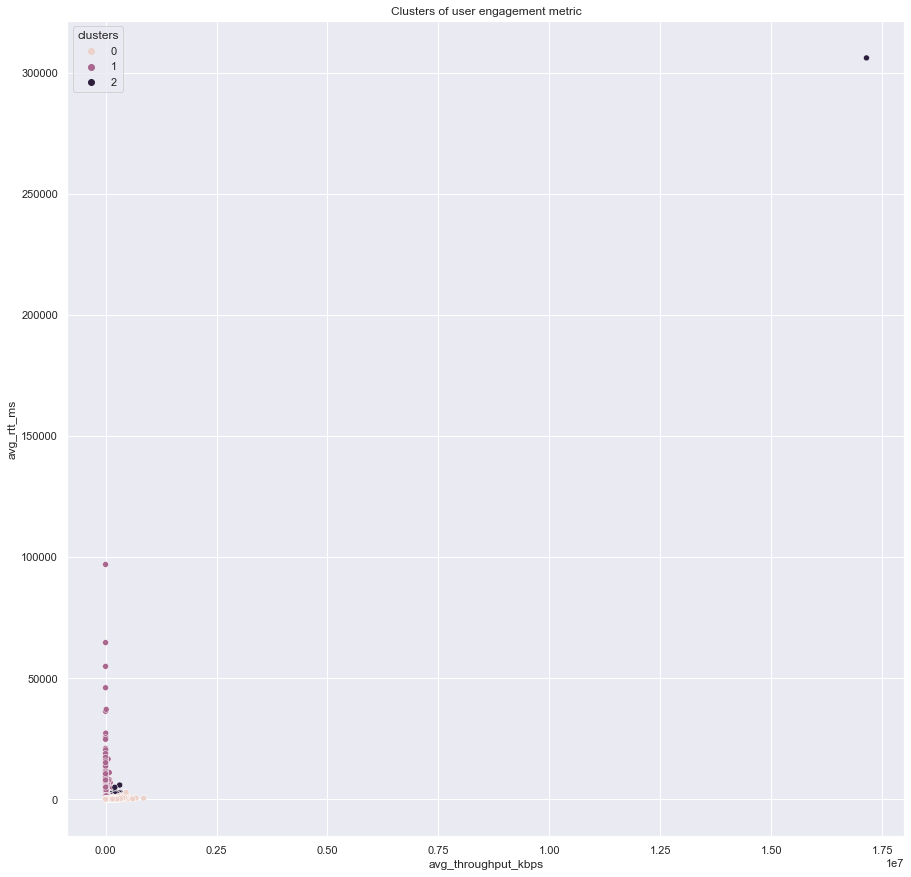

In [30]:
# labels = ['cluser_1', 'cluser_2', 'cluser_3']

# experience_metrics_with_cluster['clusters']  = experience_metrics_with_cluster['clusters'].map(lambda x:
#                                                                                              cluser_label(x, labels))

plt.figure(figsize=(15,15))

sns.scatterplot(x = 'avg_throughput_kbps', y='avg_rtt_ms',
                hue='clusters', data=experience_metrics_with_cluster).set_title('Clusters of user engagement metric')

plt.show()


In [35]:
fig = px.scatter(experience_metrics_with_cluster, x='tcp_retrans_bytes', y="avg_throughput_kbps",
                 color='clusters', size='avg_throughput_kbps')
fig.show()